In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.constants import M_sun, G, mu0
import astropy.units as u
import tqdm


sys.path.append('../my_funcs/')
from pipeline_main import pipeline
from pipeline_1D import *
sys.path.append('../my_python_utilities')


# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

Initialising patch data


100%|██████████| 4165/4165 [00:03<00:00, 1230.47it/s]


Converged mean angular momentum vector after 0 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 8977.33it/s] 


Disk size: 17.9 au
Looping through patches to extract densities and heights


100%|██████████| 4165/4165 [00:04<00:00, 964.62it/s] 


Fitting surface density and scaleheight in each radial bin


100%|██████████| 99/99 [00:01<00:00, 54.15it/s] 


Validating fit...
Calculating sound speed from scaleheights and angular velocities
Calculating azimuthal and angular velocities


100%|██████████| 4165/4165 [00:02<00:00, 1824.74it/s]


Calculating sound speed from scaleheights and angular velocities
Σ = g/cm2
φ = rad
H = au
vφ = cm/s
Ω = 1/s
cs = cm/s
Q = dimensionless
B = Gauss


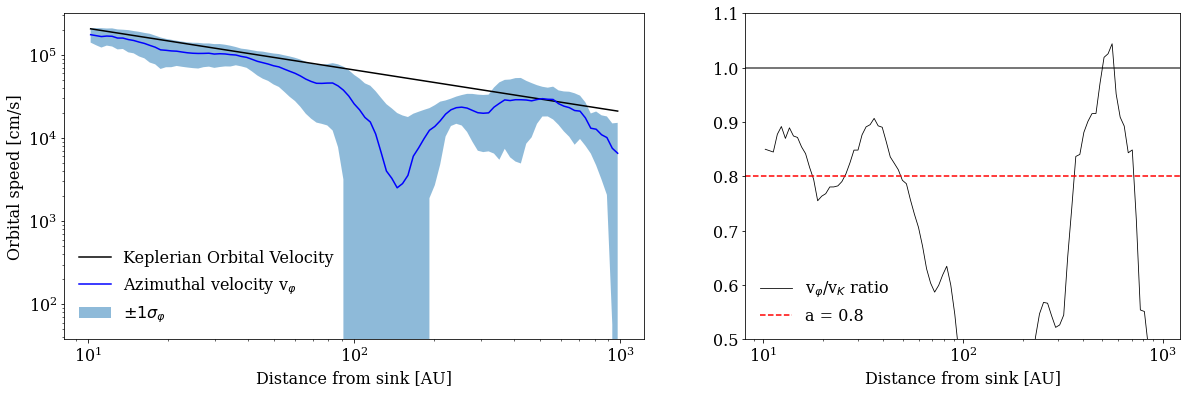

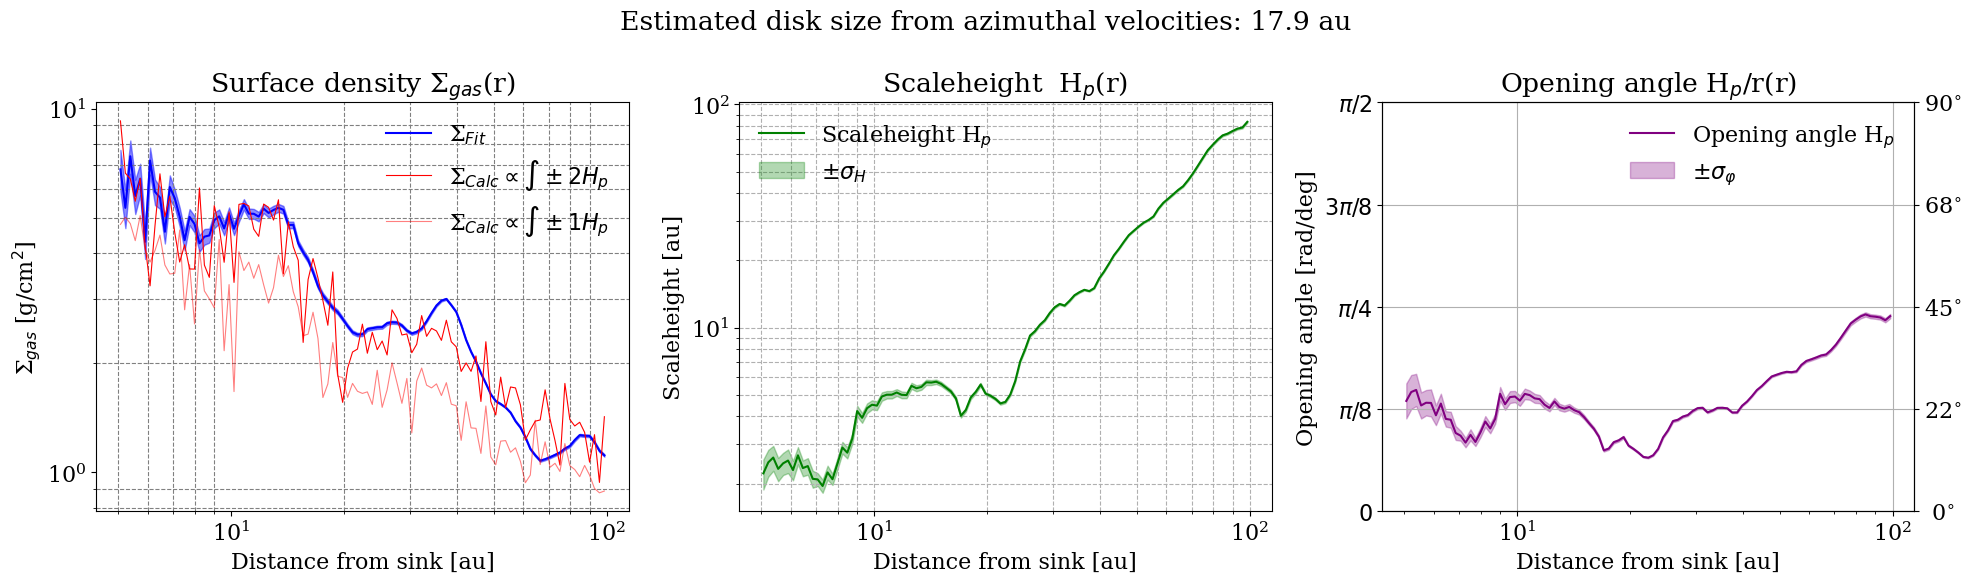

In [2]:
data = pipeline(snap = 357, run = 'my_core_13lacc', sink_id = 13)
data.recalc_L(verbose = 1); 
data.calc_disksize()
data.to_1D()
data.get_1D_param(cs = True)

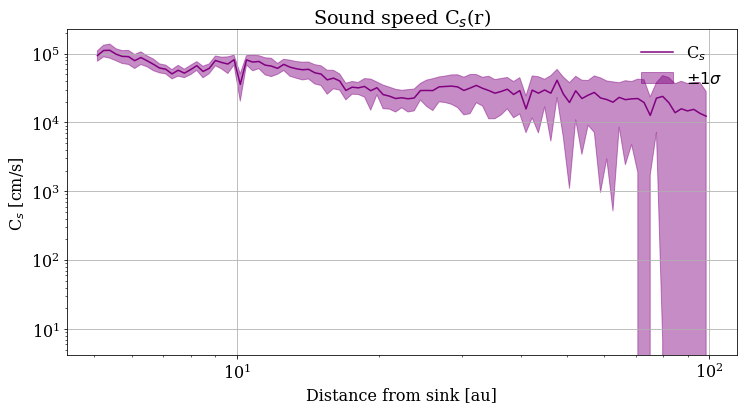

In [3]:
fig, axs = plt.subplots(figsize = (12,6))
axs.grid('--')
axs.loglog(data.r_1D * data.au_length, data.cs_1D[:,0] , color = 'purple', label = 'C$_s$')
axs.fill_between(data.r_1D * data.au_length, data.cs_1D[:,0] + data.cs_1D[:,1], data.cs_1D[:,0] - data.cs_1D[:,1], color = 'purple', alpha = 0.45, label = '$\pm 1σ$')
axs.set(title = 'Sound speed C$_s$(r)', ylabel = 'C$_s$ [cm/s]', xlabel = 'Distance from sink [au]')
axs.legend(frameon = False)

In [4]:
N_σ = 3
annulus_cs_tot = np.zeros_like(data.r_1D)
annulus_cs2_tot = np.zeros_like(data.r_1D)

print('Extracting sound speed data from patches into 1D')
for p in tqdm.tqdm(data.sn.patches):
    p.cs = np.sqrt(p.var('(px**2+py**2+pz**2)**0.5 / d'))                               
    if (p.bin_idx1D == data.Nr).all() or (p.bin_idx1D == 0).all(): continue

    for bin in np.unique(p.bin_idx1D):
        if bin == 0 or bin == data.Nr: continue                                            
        h_idx = np.nonzero(abs(p.cyl_z.flatten()[p.bin_idx1D == bin]) < ( N_σ * data.H_1D[bin - 1, 0]) / data.au_length)    
        if len(h_idx) == 0: continue                                             
        annulus_cs_tot[bin - 1] += np.sum(p.m.flatten()[p.bin_idx1D == bin][h_idx] * (p.cs.flatten()[p.bin_idx1D == bin][h_idx]))
        annulus_cs2_tot[bin - 1] += np.sum(p.m.flatten()[p.bin_idx1D == bin][h_idx] * (p.cs.flatten()[p.bin_idx1D == bin][h_idx])**2)

cs_1D = (annulus_cs_tot/data.mcode_1D) * data.cms_velocity
cs2_1D = (annulus_cs2_tot/data.mcode_1D) * data.cms_velocity**2
σcs_1D = np.sqrt(cs2_1D - cs_1D**2)

Extracting sound speed data from patches into 1D


100%|██████████| 4165/4165 [00:03<00:00, 1066.23it/s]


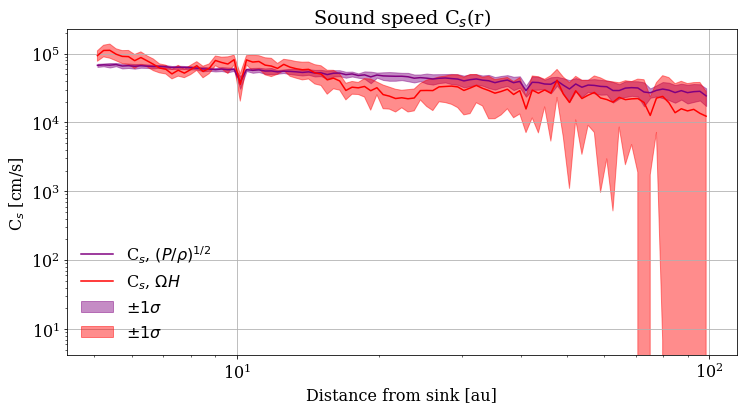

In [7]:
fig, axs = plt.subplots(figsize = (12,6))
axs.grid('--')
axs.loglog(data.r_1D * data.au_length, cs_1D , color = 'purple', label = 'C$_s$, $(P/ρ)^{1/2}$')
axs.fill_between(data.r_1D * data.au_length, cs_1D + σcs_1D, cs_1D - σcs_1D, color = 'purple', alpha = 0.45, label = '$\pm 1σ$')

axs.loglog(data.r_1D * data.au_length, data.cs_1D[:,0] , color = 'red', label = 'C$_s$, $\Omega H$')
axs.fill_between(data.r_1D * data.au_length, data.cs_1D[:,0] + data.cs_1D[:,1], data.cs_1D[:,0] - data.cs_1D[:,1], color = 'red', alpha = 0.45, label = '$\pm 1σ$')
axs.set(title = 'Sound speed C$_s$(r)', ylabel = 'C$_s$ [cm/s]', xlabel = 'Distance from sink [au]')
axs.legend(frameon = False)

In [6]:
(u.bar / (u.g / u.cm**3)).decompose()

Unit("100 m2 / s2")